In [6]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

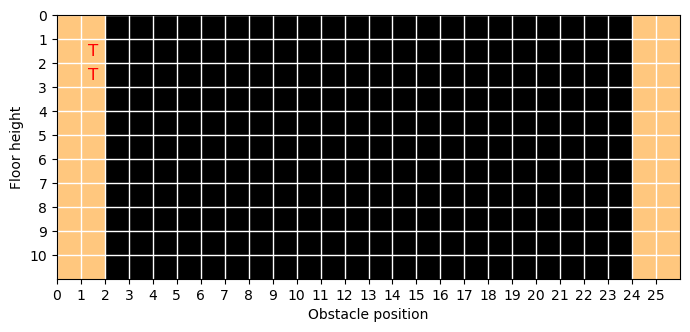

In [42]:
def plot_evaluation_grid(grid, training_positions, min_obs_position,
                         min_floor_height):
    """Plots the evaluation grid."""
    fig, ax = plt.subplots(figsize=(7, 9))
    grid_x, grid_y = grid.shape
    extent = (0, grid_x, grid_y, 0)
    ax.imshow(grid.T, extent=extent, origin='lower', cmap='copper')

    x_ticks = np.arange(grid_x)
    y_ticks = np.arange(grid_y)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_ylabel("Floor height")
    ax.set_xlabel("Obstacle position")
    
    # Loop over data dimensions and create text annotations.
    for (obstacle_pos, floor_height) in training_positions:
        pos_index = obstacle_pos - min_obs_position
        height_index = floor_height - min_floor_height
        ax.text(
            pos_index + 0.5,
            height_index + 0.5,
            'T',
            ha='center',
            va='center',
            color='r',
            fontsize='large')

    ax.grid(color='w', linewidth=1)
    fig.tight_layout()
    return fig


grid = np.zeros((26, 11))
grid[1] = np.ones(11)
grid[0] = np.ones(11)
grid[-1] = np.ones(11)
grid[-2] = np.ones(11)

fig = plot_evaluation_grid(grid, [(1 + 10, 1 + 23), (1 + 10, 2 + 23)], 10, 23)
plt.show()


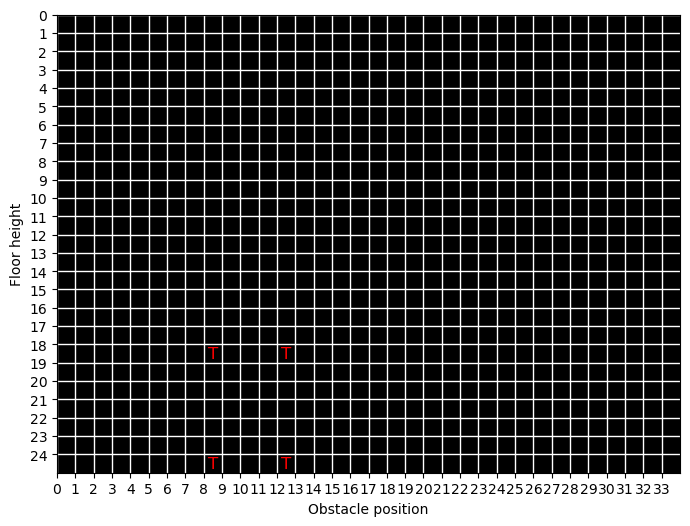

(34, 25)


In [44]:
# obstacle_pos: min: 14, max: 47
obstacle_pos = np.array(range(14, 48))
# floor_height: min: 0, max: 40
floor_height = np.array(range(10, 35))
ALL_CONFIGURATIONS = set(itertools.product(obstacle_pos, floor_height))

grid = np.zeros((len(obstacle_pos), len(floor_height)))

TRAINING_CONFIGURATIONS = set([
    # (obstacle_pos, floor_height)
    (22, 18), (22, 24),
    (26, 18), (26,24),
])
TEST_CONFIGURATIONS = ALL_CONFIGURATIONS - TRAINING_CONFIGURATIONS

fig = plot_evaluation_grid(grid, TRAINING_CONFIGURATIONS, 14, 0)
plt.show()
print(grid.shape)